In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
import torch.nn.functional as F
import pandas as pd
import seaborn as sn
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from torch.utils.data import Subset, DataLoader
from torchvision.datasets import ImageFolder

In [2]:
mean = np.array([0.5, 0.5, 0.5])
std = np.array([0.25, 0.25, 0.25])
data_transforms = {
            'Train': transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize(mean, std)
            ]),
            'Test': transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize(mean, std)
            ]),
}

In [3]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [4]:
num_epochs = 20
batch_size = 32
learning_rate = 0.001

In [5]:
data_dir = r'C:\Users\ND01VY\OneDrive - Aalborg Universitet\Desktop\thermal images UL - Split-Train-Tes'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['Train', 'Test']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size,
                                             shuffle=True, num_workers=0)
              for x in ['Train', 'Test']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['Train', 'Test']}
class_names = image_datasets['Train'].classes

print(class_names)

['BLB', 'Blast', 'healthy', 'hispa', 'leaf folder', 'leaf spot']


In [6]:
inputs, classes = next(iter(dataloaders['Train']))

In [7]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        
        self.conv1 = nn.Conv2d(3, 6, 3)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 3)
        self.dropout = nn.Dropout(0.25)
        
        self.fc1 = nn.Linear(16*58*78, 200)
        self.fc2 = nn.Linear(200, 150)
        self.fc3 = nn.Linear(150, 80)
        self.fc4 = nn.Linear(80, 6)
        

    def forward(self, x):
        
        x = self.pool(F.relu(self.conv1(x)))  
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16*58*78)            
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.dropout(x)
        x = self.fc4(x)                       
        return x


model = ConvNet().to(device)

In [8]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [9]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=num_epochs):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    loss_plt = []  
    accuracy_plt = []
    test_loss_plt = []  
    test_accuracy_plt = []
    
    
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['Train', 'Test']:
            if phase == 'Train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, classes in dataloaders[phase]:
                inputs = inputs.to(device)
                classes = classes.to(device)

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'Train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, classes)

                    # backward + optimize only if in training phase
                    if phase == 'Train':
                        optimizer.zero_grad()
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == classes.data)

            if phase == 'Train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
             
            if phase == 'Train':
                accuracy_plt.append(epoch_acc)
                loss_plt.append(epoch_loss)
                
            if phase == 'Test':
                test_accuracy_plt.append(epoch_acc)
                test_loss_plt.append(epoch_loss)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'Test' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()
    
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best Test Acc: {:4f}'.format(best_acc))
    
    plt.plot(accuracy_plt,label='Training Accuracy')  
    plt.plot(test_accuracy_plt,label='Test Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.xticks(range(0, 19))
    plt.title('Training vs Test Accuracy')
    plt.legend()
    plt.show()
    
    plt.plot(loss_plt,label='Training Loss')  
    plt.plot(test_loss_plt,label='Test Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.xticks(range(0, 19))
    plt.title('Training vs Test Loss')
    plt.legend()
    plt.show()
    
    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

Epoch 0/19
----------
Train Loss: 2.0871 Acc: 0.2795
Test Loss: 1.7008 Acc: 0.3438

Epoch 1/19
----------
Train Loss: 1.6092 Acc: 0.3878
Test Loss: 1.4320 Acc: 0.4688

Epoch 2/19
----------
Train Loss: 1.3589 Acc: 0.4488
Test Loss: 1.1437 Acc: 0.6094

Epoch 3/19
----------
Train Loss: 1.0781 Acc: 0.5886
Test Loss: 0.9309 Acc: 0.6406

Epoch 4/19
----------
Train Loss: 0.8947 Acc: 0.6634
Test Loss: 0.8204 Acc: 0.6719

Epoch 5/19
----------
Train Loss: 0.7046 Acc: 0.7598
Test Loss: 0.7891 Acc: 0.6953

Epoch 6/19
----------
Train Loss: 0.5834 Acc: 0.7933
Test Loss: 0.6465 Acc: 0.7656

Epoch 7/19
----------
Train Loss: 0.4943 Acc: 0.8169
Test Loss: 0.5549 Acc: 0.8281

Epoch 8/19
----------
Train Loss: 0.4070 Acc: 0.8780
Test Loss: 0.5123 Acc: 0.8281

Epoch 9/19
----------
Train Loss: 0.3770 Acc: 0.8661
Test Loss: 0.5420 Acc: 0.8203

Epoch 10/19
----------
Train Loss: 0.3812 Acc: 0.8642
Test Loss: 0.5150 Acc: 0.8359

Epoch 11/19
----------
Train Loss: 0.3456 Acc: 0.8858
Test Loss: 0.5286 Acc

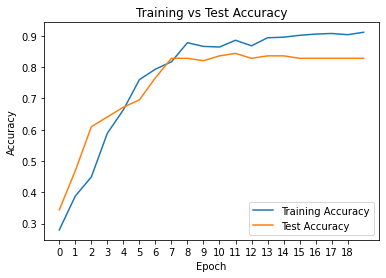

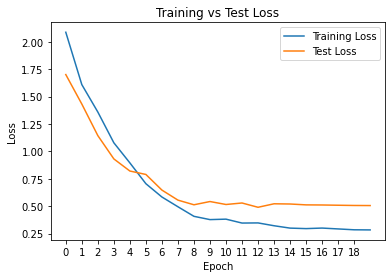

In [10]:
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

model = train_model(model, criterion, optimizer,
                         exp_lr_scheduler, num_epochs=num_epochs)

In [11]:
inputs, labels = next(iter(dataloaders['Test']))

<AxesSubplot:>

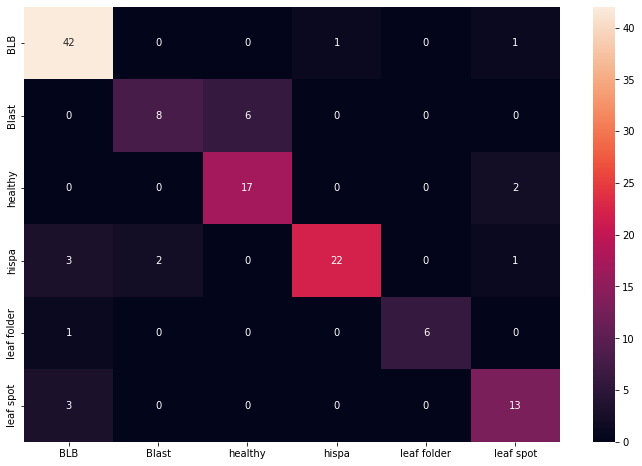

In [12]:
y_pred = []
y_true = []

# iterate over test data
for inputs, labels in dataloaders['Test']:
        output = model(inputs) 

        output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
        y_pred.extend(output) # Save Prediction
        
        labels = labels.data.cpu().numpy()
        y_true.extend(labels) # Save Truth


classes = ('BLB', 'Blast', 'healthy', 'hispa', 'leaf folder', 'leaf spot')

# Build confusion matrix
cf_matrix = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cf_matrix, index = [i for i in classes], columns = [i for i in classes])
plt.figure(figsize = (12,8))
sn.heatmap(df_cm, annot=True)
#plt.savefig('output.png')

In [13]:
from sklearn.metrics import classification_report
print(classification_report(y_pred, y_true, target_names=classes))

              precision    recall  f1-score   support

         BLB       0.95      0.86      0.90        49
       Blast       0.57      0.80      0.67        10
     healthy       0.89      0.74      0.81        23
       hispa       0.79      0.96      0.86        23
 leaf folder       0.86      1.00      0.92         6
   leaf spot       0.81      0.76      0.79        17

    accuracy                           0.84       128
   macro avg       0.81      0.85      0.83       128
weighted avg       0.86      0.84      0.85       128



In [14]:
from sklearn.metrics import precision_recall_fscore_support
res = []
for l in [0,1,2,3,4,5]:
     prec,recall,_,_ = precision_recall_fscore_support(np.array(y_true)==l, np.array(y_pred)==l, pos_label=True,average=None)
     res.append([l,recall[0],recall[1]])

pd.DataFrame(res,columns = ['class','sensitivity','specificity'])

,class,sensitivity,specificity
0,0,0.916667,0.954545
1,1,0.982456,0.571429
2,2,0.944954,0.894737
3,3,0.990000,0.785714
4,4,1.000000,0.857143
5,5,0.964286,0.812500
